# 예측 애널리틱스: 합성곱신경망

In [44]:
dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)
X, y = dataset.data.numpy().reshape(-1, 28*28) , dataset.targets.numpy()

In [41]:
(model.predict(train_x.reshape(-1,28*28)) == train_y.numpy()).sum()

46036

In [37]:
(model.predict(train_x.reshape(-1,28*28)) == train_y)

False

In [18]:
dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)
X, y = dataset.data.numpy() , dataset.targets.numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(60000,28*28))


In [14]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X.reshape(-1,28*28),y)

KeyboardInterrupt: 

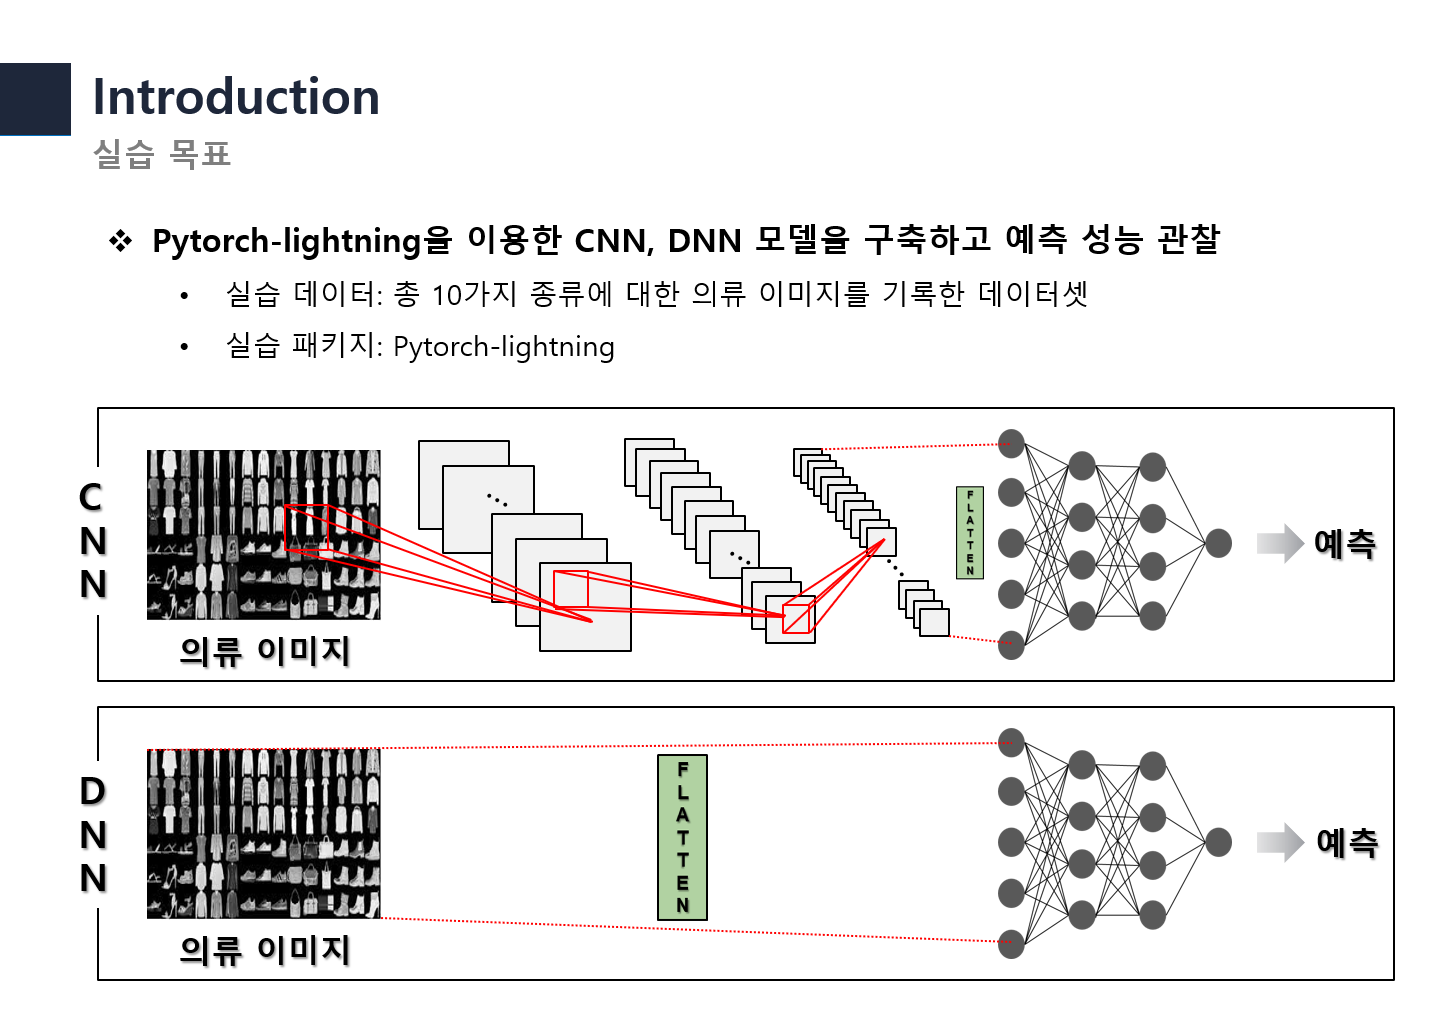

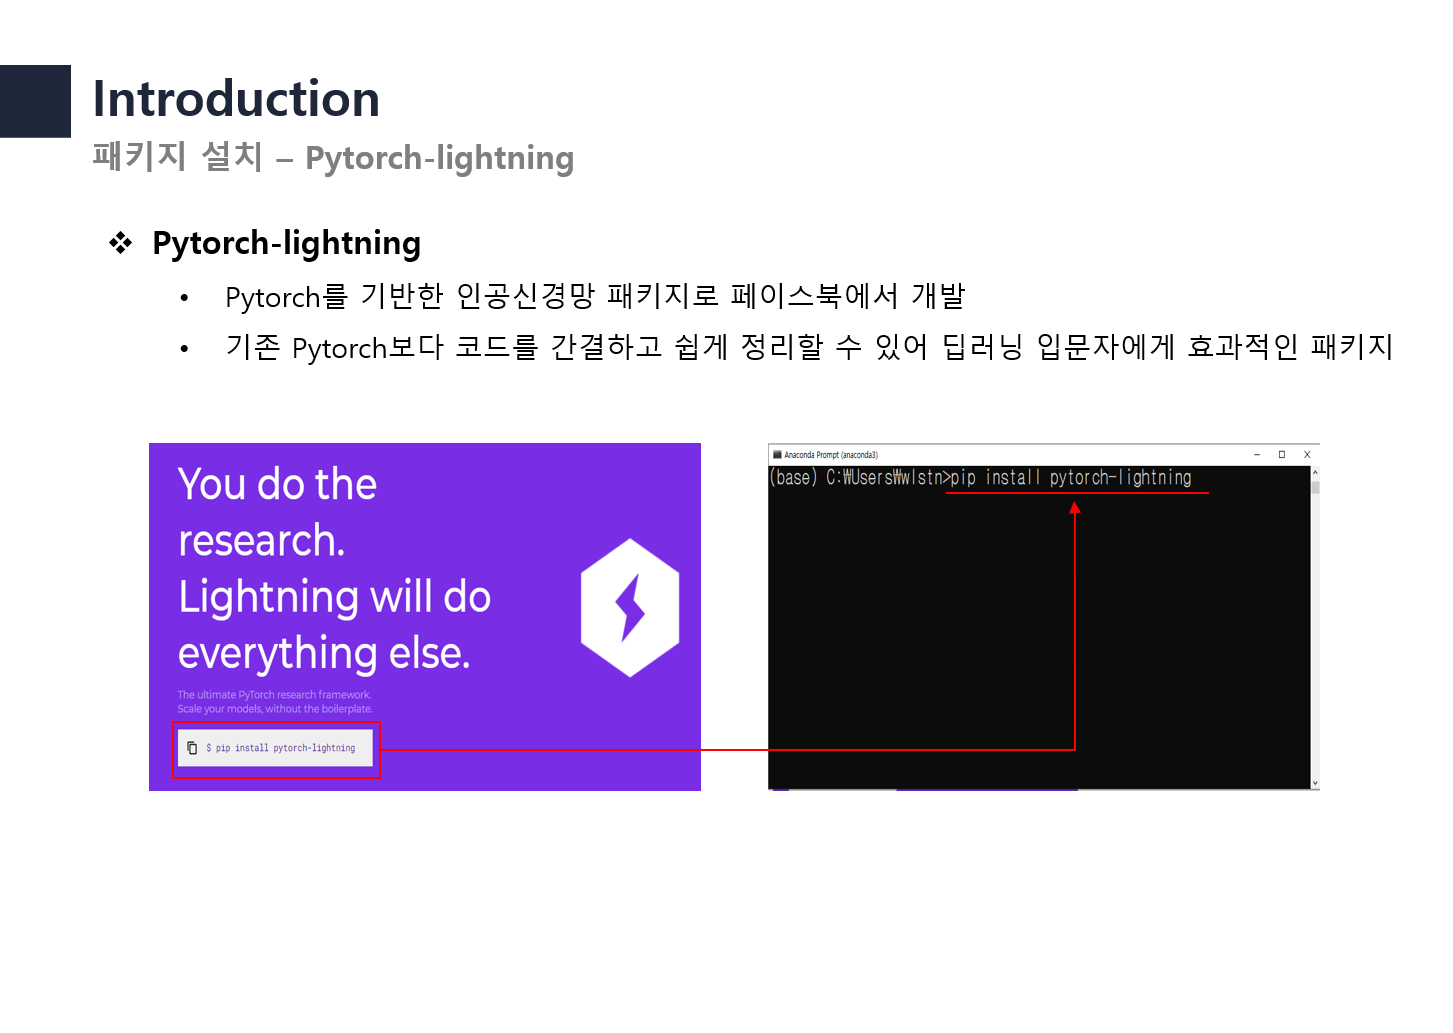

## 1. 모듈 불러오기

In [1]:
# 실습용 데이터 패키지
from torchvision.datasets import FashionMNIST

# 데이터 전처리 패키지
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler

# 기계학습 모델 패키지 : 파이토치 라이토닝
import torch
import torch.nn as nn
import torch.nn.functional as F
#!pip install pytorch-lightning # Pytorch-lightning 패키지 다운로드 코드입니다 ! 없으시면 다운로드 하시죠 ~!
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.metrics import functional as FM


# 데이터 시각화 패키지
# %matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic') # 한글 폰트 설정

# 예측 평가 지표 패키지
from sklearn.metrics import accuracy_score, confusion_matrix

# 예측 결과 시각화 custom 함수
def plot_confusion_matrix(cm, classes,title, cmap=plt.cm.Blues):
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black",fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# CNN filter 시각화 함수
def show_filter_filter(parameter_path):

    # parameter load
    parameter = torch.load(parameter_path)['state_dict']
    
    # conv1.weight load
    conv1 = parameter['conv1.weight'].detach().cpu().numpy().reshape(1,10,3,3)
    for chanel_ind , chanel in enumerate(conv1):

        fig = plt.figure(figsize=(20,5))
        plt.title(f'CONV1 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(2,5,ind + 1)
            ax.imshow(img, interpolation='nearest',cmap = 'gray')
            ax.set_xticks([]), ax.set_yticks([])
            
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)
        
    # conv2.weight load
    conv2 = parameter['conv2.weight'].detach().cpu().numpy().reshape(20,10,3,3)
    for chanel_ind , chanel in enumerate(conv2):

        fig = plt.figure(figsize=(20,5))
        plt.title(f'CONV2 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(2,5,ind + 1)
            ax.imshow(img, interpolation='nearest',cmap = 'gray')
            ax.set_xticks([]), ax.set_yticks([])
    
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)
        
    
    # conv3.weight load
    conv3 = parameter['conv3.weight'].detach().cpu().numpy().reshape(40,20,3,3)
    for chanel_ind , chanel in enumerate(conv3):

        fig = plt.figure(figsize=(20,10))
        plt.title(f'CONV3 filter - type : {chanel_ind}')
        for ind, img in enumerate(chanel):
            ax = fig.add_subplot(4,5,ind + 1)
            ax.imshow(img, interpolation='nearest',cmap = 'gray')
            ax.set_xticks([]), ax.set_yticks([])
    
            for i, j in itertools.product(range(img.shape[0]), range(img.shape[1])):
                plt.text(j, i, round(img[i, j],2),
                horizontalalignment="center",color="red",fontsize=12)

    plt.show()

# 기타
import warnings, itertools, time
warnings.filterwarnings(action='ignore')

## 2. 데이터 불러오고 로더 만들기

In [2]:
# Fashion MNIST 데이터를 저장할 directory
download_root = './'

# 데이터 scaling을 위한 요소
fasion_mnist_transform = transforms.Compose([
    transforms.ToTensor(), # 데이터 형태를 Pytorch에 적합한 형태로 바꾸어 줌
    transforms.Normalize((0.0,), (1.0,)) # feature들의 평균과 표준편차를 0과 1로 scaling 해줌
])

#FashionMNIST 훈련 데이터셋 다운로드
dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=True, download=True)

# 훈련 데이터셋을 50000개(학습용) / 10000개(검증용)으로 분리
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

# 테스트 데이터셋 다운로드
test_dataset = FashionMNIST(download_root, transform=fasion_mnist_transform, train=False, download=True)

In [ ]:
# 데이터를 100개 단위의 미니 배치로 구분지어 인공신경망 학습
train_loader = DataLoader(train_dataset,batch_size=100)
valid_loader = DataLoader(valid_dataset,batch_size=100)
test_loader = DataLoader(test_dataset,batch_size=100)

## 3. Pytorch-lightning을 이용한 CNN 모델 구현

### 3.1 모델 구축

#### CNN

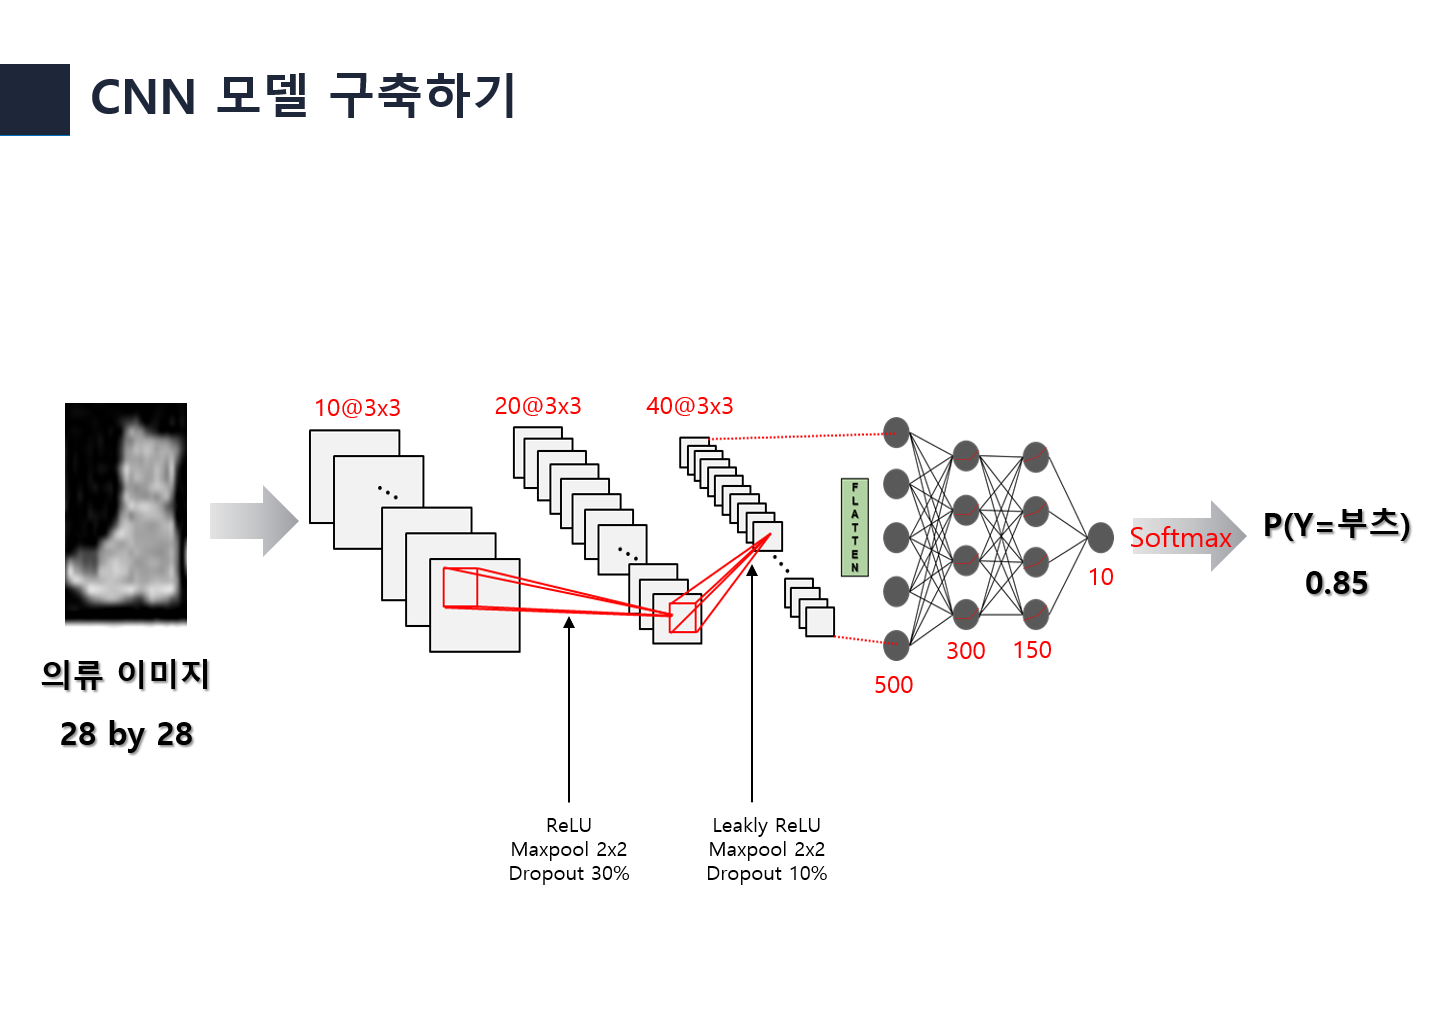

In [ ]:
class CNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()

        # convolution
        self.conv1 = nn.Conv2d(1,10,(3,3))
        self.conv2 = nn.Conv2d(10,20,(3,3))
        self.conv3 = nn.Conv2d(20,40,(3,3))
        
        # pooling layer
        self.max_pool = nn.MaxPool2d((2,2),2)
        
        # dropout 
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        # activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1,inplace=True)
        
        # clasifier
        self.classifier = nn.Sequential(nn.Linear(500, 300),
                                        self.relu,
                                        self.dropout_1,
                                        nn.Linear(300,100),
                                        self.lrelu,
                                        self.dropout_2,
                                        nn.Linear(100, class_num))
        
        # for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        # for convenient
        self.class_num = class_num

    def forward(self,x): # x is input data
        
        # x -> convolution -> relu -> max_pool -> dropout
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.dropout_1(x)
        
        # .. -> convolution -> relu -> max_pool -> dropout
        x = self.conv2(x)
        x = self.lrelu(x)
        x = self.max_pool(x)
        x = self.dropout_2(x)
        
        # .. -> classifier -> logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self,batch,batch_idx):
        x, y = batch
        logit = self(x) # self(x)는 model(input)와 같다고 이해하시면 됩니다.
        prob = F.softmax(logit,dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y) 
        logs = {'train_loss':loss,'train_acc':train_accuracy}
        result = {'loss':loss,'log':logs,'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'train_acc':avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        return epoch_result

    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result

    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):

        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)

        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target= target.detach().cpu().numpy()

#### DNN

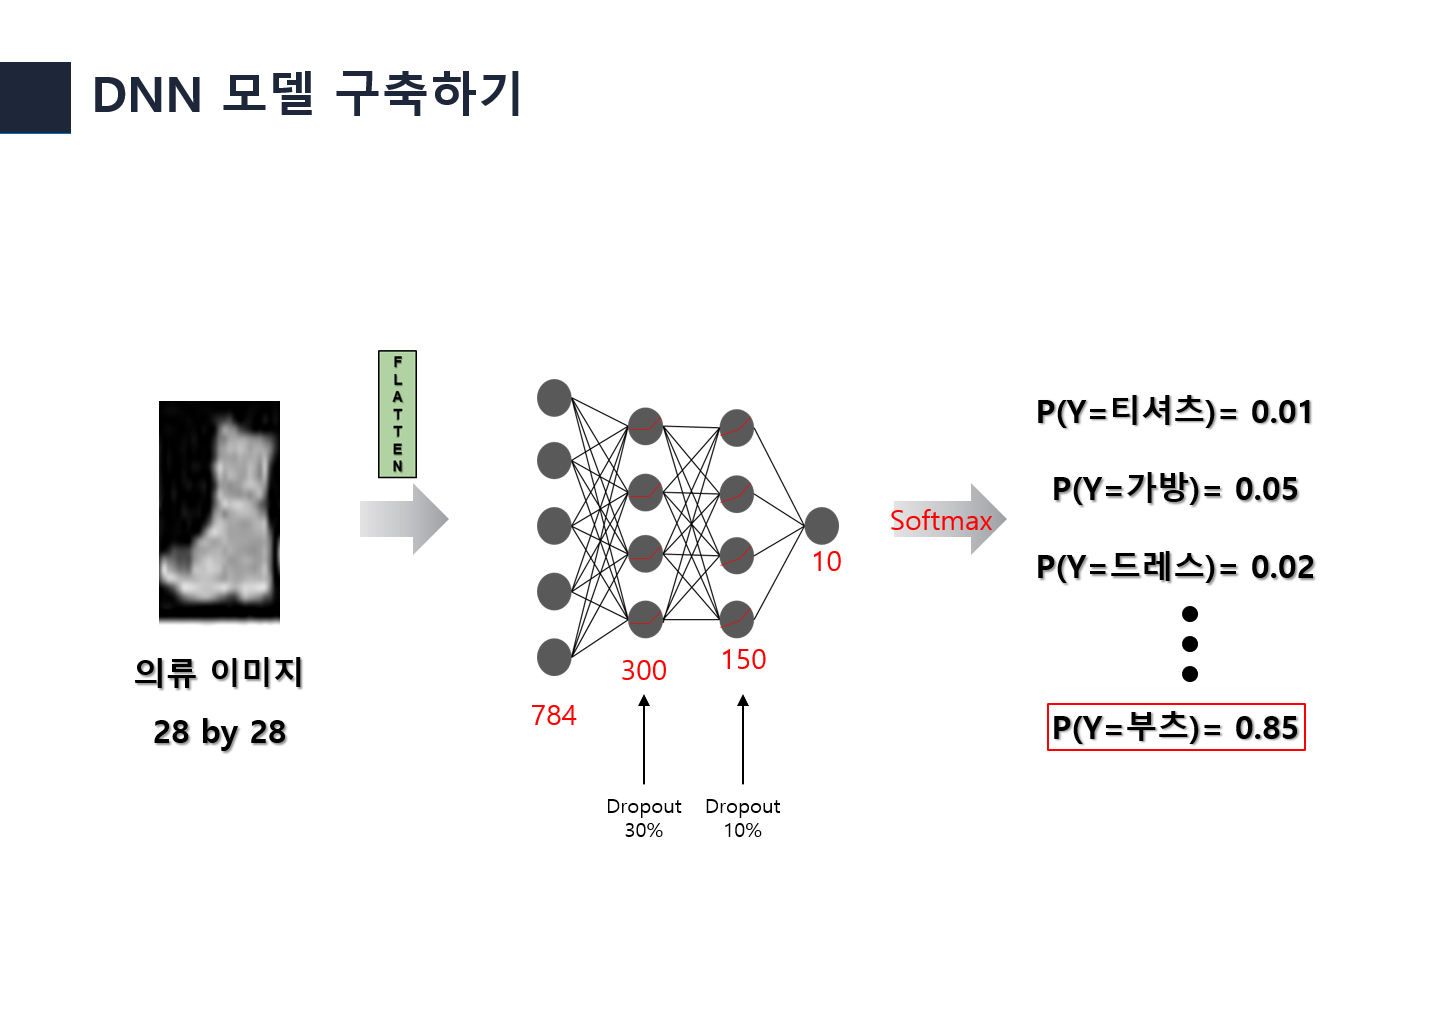

In [ ]:
class DNN(pl.LightningModule):
    def __init__(self, class_num):
        super().__init__()
        
        # dropout 
        self.dropout_1 = nn.Dropout(p=0.3)
        self.dropout_2 = nn.Dropout(p=0.1)
        
        # activation function
        self.relu = nn.ReLU(inplace=True)
        self.lrelu = nn.LeakyReLU(negative_slope=0.1,inplace=True)
        
        # clasifier
        self.classifier = nn.Sequential(nn.Linear(28*28, 300),
                                        self.relu,
                                        self.dropout_1,
                                        nn.Linear(300,100),
                                        self.lrelu,
                                        self.dropout_2,
                                        nn.Linear(100, class_num))
        
        # for logging
        self.train_loss_ = []
        self.train_acc_ = []
        self.val_loss_ = []
        self.val_acc_ = []
        
        # for convenient
        self.class_num = class_num
        
    def forward(self,x): # x is input data
        
        # x -> classifier -> logit
        flatten = x.view(x.size(0),-1)
        logit = self.classifier(flatten)
        
        return logit
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters() , lr = 0.001)
        return optimizer
    
    def training_step(self,batch,batch_idx):
        x, y = batch
        logit = self(x)
        prob = F.softmax(logit,dim=1)
        train_accuracy = FM.accuracy(prob,y)
        loss = F.cross_entropy(logit,y) 
        logs = {'train_loss':loss,'train_acc':train_accuracy}
        result = {'loss':loss,'log':logs,'train_acc':train_accuracy}
        return result
    
    def training_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['train_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'train_acc':avg_acc}
        self.train_loss_.append(avg_loss.cpu().numpy().item())
        self.train_acc_.append(avg_acc.cpu().numpy().item())
        return epoch_result

    def validation_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        val_accuracy = FM.accuracy(y_hat_prob,y)
        val_loss = F.cross_entropy(y_hat,y)
        logs = {'val_accuracy':val_accuracy,'val_loss':val_loss}
        result = {'loss':val_loss,'log':logs,'val_acc':val_accuracy}
        return result
    
    def validation_epoch_end(self,result):
        avg_loss = torch.stack([x['loss'] for x in result]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in result]).mean()
        epoch_result = {'loss':avg_loss,'acc':avg_acc}
        self.val_loss_.append(avg_loss.cpu().numpy().item())
        self.val_acc_.append(avg_acc.cpu().numpy().item())
        self.log('val_accuracy',avg_acc)
        return epoch_result
    
    def test_step(self,batch,batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_prob = F.softmax(y_hat,dim=1)
        result = {'predicted':y_hat_prob,'target':y}
        return result
    
    def test_epoch_end(self,result):

        predicted = torch.stack([x['predicted'] for x in result])
        predicted = predicted.view(-1,self.class_num)
        target = torch.stack([x['target'] for x in result])
        target = target.view(-1)

        self.test_predicted = predicted.detach().cpu().numpy()
        self.test_target= target.detach().cpu().numpy()

### 3.2 모델 학습

#### CNN

In [ ]:
start = time.time()  # 모델 학습 시작 시간 저장
cnn = CNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') # Early stopping
checkpoint = ModelCheckpoint(filename='./CNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) # Model parameter save
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0) # 컴퓨터에 GPU가 있으신 분들은 0을 1로 변경하세요 ! 지피유 이용이 가능합니다.
trainer.fit(cnn,train_loader,valid_loader)
print("time :", time.time() - start) # 학습 소요 시간 출력

#### DNN

In [ ]:
start = time.time()  # 모델 학습 시작 시간 저장
dnn = DNN(class_num=10)
early_stop = EarlyStopping(monitor='val_accuracy',patience=5,verbose=True,mode='max') # Early stopping
checkpoint = ModelCheckpoint(filename='./DNN-{epoch}-{val_accuracy}',monitor='val_accuracy',mode='max',save_top_k=1) # Model parameter save
trainer = pl.Trainer(callbacks=[early_stop,checkpoint],gpus=0)
trainer.fit(dnn,train_loader,valid_loader)
print("time :", time.time() - start) # 학습 소요 시간 출력

### 3.3 학습 현황 확인 및 예측 결과 출력

In [ ]:
# CNN logs
cnn_train_loss = cnn.train_loss_
cnn_train_acc = cnn.train_acc_
cnn_valid_loss = cnn.val_loss_
cnn_valid_acc = cnn.val_acc_

# DNN logs
dnn_train_loss = dnn.train_loss_
dnn_train_acc = dnn.train_acc_
dnn_valid_loss = dnn.val_loss_
dnn_valid_acc = dnn.val_acc_

# 그래프 배경화면 만들기
f, axs = plt.subplots(4,1,figsize=(20,30))

# 학습로스 변동 관찰하기
axs[0].plot(cnn_train_loss,label='CNN 학습 로스')
axs[0].plot(dnn_train_loss,label='DNN 학습 로스')
axs[0].legend()

# 학습 정확도 변동 관찰하기
axs[1].plot(cnn_train_acc,label='CNN 학습 정확도')
axs[1].plot(dnn_train_acc,label='DNN 학습 정확도')
axs[1].legend()

# 검증용 데이터에 대한 Accuracy 변동 관찰하기
axs[2].plot(cnn_valid_acc,label='CNN검증 정확도')
axs[2].scatter(np.argmax(cnn_valid_acc),np.max(cnn_valid_acc),s=100,facecolors='none',edgecolors='r',
              label='CNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].plot(dnn_valid_acc,label='DNN검증 정확도')
axs[2].scatter(np.argmax(dnn_valid_acc),np.max(dnn_valid_acc),s=100,facecolors='none',edgecolors='r',
              label='DNN 최적의 학습 체크포인트(=학습 중단점)')
axs[2].legend()


# 검증용 데이터에 대한 loss 변동 관찰하기
axs[3].plot(cnn_valid_loss,label='CNN 검증 로스')
axs[3].plot(dnn_valid_loss,label='DNN 검증 로스')
axs[3].legend()

plt.show()

In [ ]:
# test Accuracy 확인하기

trainer.test(model=cnn, test_dataloaders=test_loader) # test data에 대한 예측 수행
trainer.test(model=dnn, test_dataloaders=test_loader) # test data에 대한 예측 수행

cnn_test_accuracy = accuracy_score(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
dnn_test_accuracy = accuracy_score(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
print(f"CNN 분류 정확도: {cnn_test_accuracy:.3f}",f"DNN 분류 정확도: {dnn_test_accuracy:.3f}",sep='  |  ') 

In [ ]:
confusion_matrix_ = confusion_matrix(y_pred=cnn.test_predicted.argmax(1),y_true=cnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='CNN을 이용한 Fashion MNIST 예측 결과')

In [ ]:
confusion_matrix_ = confusion_matrix(y_pred=dnn.test_predicted.argmax(1),y_true=dnn.test_target)
plot_confusion_matrix(cm = confusion_matrix_, classes=dataset.classes,title='DNN을 이용한 Fashion MNIST 예측 결과')

In [ ]:
for_visualization_test_x = test_dataset.data.numpy()[:100]
for_visualization_test_y = test_dataset.targets.numpy()[:100]

f ,axs = plt.subplots(10,10,figsize=(20,20))
plt.subplots_adjust(hspace=0.8)
for i in range(10):
    for j in range(10):
        
        x_data = for_visualization_test_x[10*i+j]
        y_data = for_visualization_test_y[10*i+j]
        real_class = dataset.classes[y_data]
        predicted_class = dataset.classes[cnn.test_predicted[10*i+j].argmax()]
        predicted_prob = cnn.test_predicted[10*i+j].max()
        
        # x, y 축의 지점 표시를 안함
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

        # subplot의 제목을 i번째 결과에 해당하는 숫자로 설정
        axs[i,j].set_title(f"실제 class:{real_class}\n예측 class:{predicted_class}\nProbability:{predicted_prob:.2f}")

        # 입력으로 사용한 i번째 테스트 이미지를 28x28로 재배열하고
        # 이 2차원 배열을 그레이스케일 이미지로 출력
        axs[i,j].imshow(x_data.reshape((28, 28)),cmap=plt.cm.gray_r)
 
plt.show()

In [ ]:
parameter_path = "./lightning_logs/version_11/checkpoints/CNN-epoch=34-val_accuracy=0.9134000539779663.ckpt"
show_filter_filter(parameter_path)

# EOD